In [1]:
import os 
#os.sys.path.append('/usr/lib/python3.7')
#os.sys.path.append('/usr/lib/python3.7')
#os.sys.path.append('/opt/conda/lib/python37.zip')
#os.sys.path.append('/opt/conda/lib/python37.zip')
#os.sys.path.append('/opt/conda/lib/python37.zip')
#os.sys.path.append('/opt/conda/lib/python37.zip')
#, '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '/opt/conda/lib/python3.7/site-packages')
print(os.sys.path)

['/data/licence_plate/_plate/synthesis', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/denoising_diffusion_pytorch-0.7.1-py3.7.egg', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']


In [2]:


import cv2
import numpy as np
import random
import copy
from scipy.stats import norm



In [3]:
from matplotlib import pyplot as plt

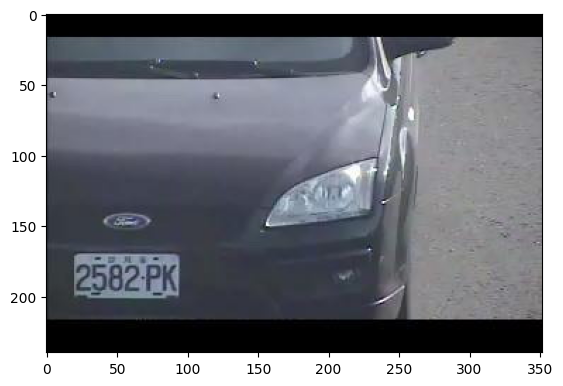

In [4]:
img = cv2.imread('03-1.jpg')

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

# Add Rain Effect

In [5]:
def generate_random_lines(imshape, slant,step_ratio=1.0):
    drops = []
    area = imshape[0] * imshape[1]
    drops_num = int(area//np.random.randint(600, 700)*step_ratio)

    for i in range(drops_num): ## If You want heavy rain, try increasing this
        if slant<0:
            x1 = np.random.randint(slant, imshape[1])
        else:
            x1 = np.random.randint(0, imshape[1]-slant)
        drop_length = np.random.randint(10, 60)
        y1 = np.random.randint(0, imshape[0]-drop_length)
        x2 = x1 + slant
        y2 = y1 + drop_length
        drops.append((x1, y1, x2, y2))
    
    return drops


def rain_process(image, rain_drops, drop_color):
    imshape = image.shape  
    image_t = image.copy()
    for rain_drop in rain_drops:
        pt1 = (rain_drop[0], rain_drop[1])
        pt2 = (rain_drop[2], rain_drop[3])
        drop_width = np.random.randint(1, 3)
        cv2.line(image_t, pt1, pt2, drop_color, drop_width)
    
    return image_t


def add_rain(image, slant=None, drop_color=(200,200,200)):
    imshape = image.shape
    if slant is None:
        slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
    rain_drops = generate_random_lines(imshape, slant)
    output = rain_process(image, rain_drops, drop_color)

    return output

def add_rain_step(image, slant=None, drop_color=(200,200,200),step_ratio=1.0,return_slant=False):
    imshape = image.shape
    if slant is None:
        slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
    rain_drops = generate_random_lines(imshape, slant,step_ratio)
    output = rain_process(image, rain_drops, drop_color)
    if return_slant:
        return output,slant
    else:
        return output

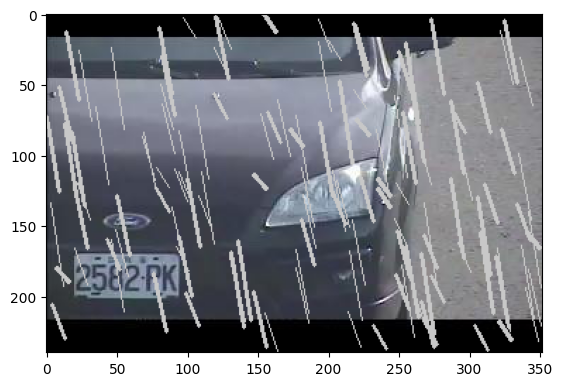

In [6]:
img2 = img.copy()
img2 = add_rain(img2)
#img2 = add_rain_step(img2,step_ratio=0.01)

RGB_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

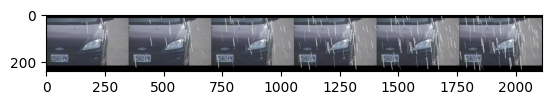

In [7]:
img2 = img.copy()
#img2 = add_rain(img2)
img2,slant = add_rain_step(img2,step_ratio=0.01,return_slant=True)
_img2 = copy.deepcopy(img2)
for i in range(100):
    img2 = add_rain_step(img2,step_ratio=0.01,slant = slant)
    if i%20==19:
        _img2 = np.concatenate((_img2,img2),axis=1)
        
RGB_img2 = cv2.cvtColor(_img2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img2)




# Add Spot Light

In [8]:
def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False,
                             reverse=False):
    """
    Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: list of tuple of integers (x, y) defining the center of spotlight light position,
                  which is the reference point during rotating, format=[(w1,h1), (w2,h2)]
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
        speedup: use `shrinkage then expansion` strategy to speed up vale calculation
        reverse: center point is dark or bright (default: bright)
    Return:
        light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                    minimum value could be smaller than given min_brightness.
    """
    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    if reverse:
        mask = 255 - mask
    return mask

def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
    """
    _decay_value_radically_norm function in matrix format
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask

def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None, reverse=False):
    """
    Add mask generated from spot light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = image
    frame = np.asarray(frame, dtype=np.float32)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate,
                                    reverse=reverse)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    #print(width)
    #print(height)
    #plt.imshow(mask)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame[frame < 0] = 0
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

def add_spot_light_randreverse(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    reverse=False
    if np.random.random(size=1)>0.5:
        reverse=True
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = image
    frame = np.asarray(frame, dtype=np.float32)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate,
                                    reverse=reverse)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    #print(width)
    #print(height)
    #plt.imshow(mask)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame[frame < 0] = 0
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

def add_spot_light_step(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None,step_ratio=1.0,reverse=False):
    """
    Add mask generated from spot light to given image
    """
    image=copy.deepcopy(image)
    reverse=False
    if np.random.random(size=1)>0.5:
        reverse=True
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    transparency = 1-(1-transparency)*step_ratio
    frame = image
    frame = np.asarray(frame, dtype=np.float32)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate,
                                    reverse=reverse,
                                   )
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    #print(width)
    #print(height)
    #plt.imshow(mask)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame[frame < 0] = 0
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

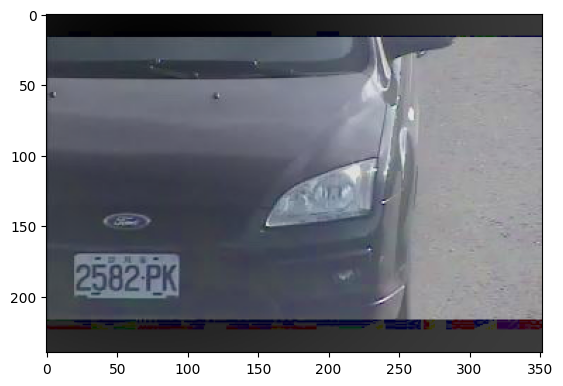

In [9]:
img3 = img.copy()
#img3 = add_spot_light(img3)
img3 = add_spot_light(img3,light_position=[(74, 58)],transparency=0.7622648419128439,reverse=True)

RGB_img = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

[(62, 197)]
0.5
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


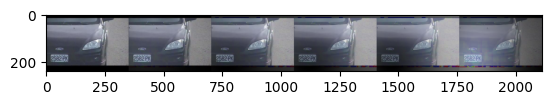

In [10]:
img3 = img.copy()
#img2 = add_rain(img2)
_img3 = copy.deepcopy(img3)
#settings
reverse=False
#if np.random.random(size=1)>0.5:
#    reverse=True
transparency = 0.5#random.uniform(0.5, 0.85)
frame = img3
frame = np.asarray(frame, dtype=np.float32)
height, width, _ = frame.shape
mask_size=(width, height)
position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]

#
print(position)
print(transparency)
print(reverse)
#add +

for i in range(100):
    img3p = add_spot_light_step(img3,step_ratio=i*0.01,light_position=position,transparency=transparency,reverse=reverse)
    print(reverse)

    if i%20==19:
        _img3 = np.concatenate((_img3,img3p),axis=1)
        
RGB_img3p = cv2.cvtColor(_img3, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img3p)


[(94, 71)]
0.5
True


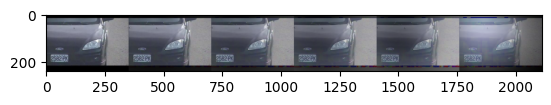

In [11]:
img3 = img.copy()
#img2 = add_rain(img2)
_img3 = copy.deepcopy(img3)
#settings
reverse=True
transparency = 0.5#random.uniform(0.5, 0.85)
frame = img3
frame = np.asarray(frame, dtype=np.float32)
height, width, _ = frame.shape
mask_size=(width, height)
position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]

#
print(position)
print(transparency)
print(reverse)
#add -

for i in range(100):
    img3p = add_spot_light_step(img3,step_ratio=i*0.01,light_position=position,transparency=transparency,reverse=reverse)
    if i%20==19:
        _img3 = np.concatenate((_img3,img3p),axis=1)
        
RGB_img3m = cv2.cvtColor(_img3, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img3m)


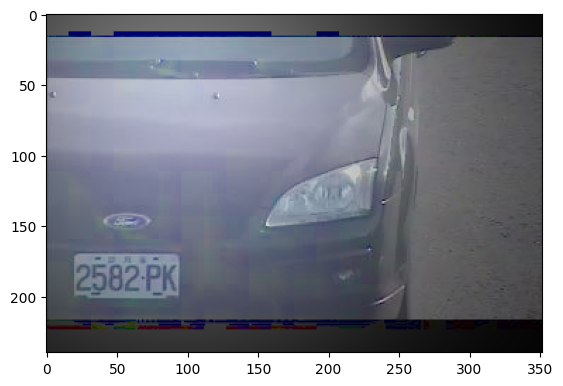

In [12]:
RGB_img3p_ = cv2.cvtColor(img3p, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img3p_)


# Adjust Gamma

In [13]:
def adjust_gamma(image, gamma=1.0):
    image=copy.deepcopy(image)
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    if gamma == 1.0:
        gamma = np.random.randint(40,91) / 100.0
        #gamma = np.random.randint(50,150) / 100.0
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    #print(table)
    return cv2.LUT(image, table)

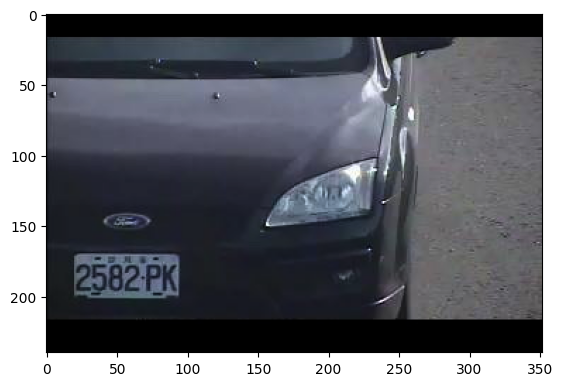

In [14]:
img4 = img.copy()
img4 = adjust_gamma(img4,gamma=0.68)
#img4 = adjust_gamma(img4)

RGB_img = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

0.4


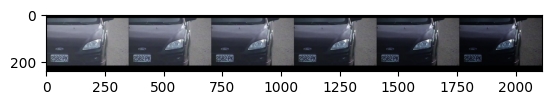

In [15]:
gamma = 0.4#np.random.randint(40,91) / 100.0

img4 = img.copy()
_img4 = copy.deepcopy(img4)
print(gamma)
for i in range(100):
    img4p = adjust_gamma(img4,gamma=1-(1-gamma)*i*0.01)
    if i%20==19:
        _img4 = np.concatenate((_img4,img4p),axis=1)
RGB_img4 = cv2.cvtColor(_img4, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img4)

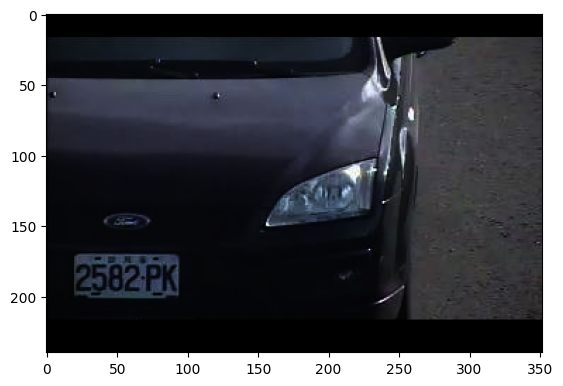

In [16]:
RGB_img4p = cv2.cvtColor(img4p, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img4p)

# Decrease Resolution

In [17]:
def pixelate(image, blocks=None,step_ratio=1.0):
    input_image_copy=copy.deepcopy(image)
    # divide the input image into NxN blocks
    st_ratio=0.5+step_ratio*0.5
    if blocks is None:
        blocks = np.random.randint(120,151)
        
    (h, w) = image.shape[:2]
    #Xblocks=w-(w-blocks)*st_ratio
    #Yblocks=h-(h-blocks)*st_ratio
    Xblocks=blocks*st_ratio+(1-st_ratio)*w
    Yblocks=blocks*st_ratio+(1-st_ratio)*h
    print(Xblocks)


    xSteps = np.linspace(0, w, int(Xblocks) + 1, dtype="int")
    ySteps = np.linspace(0, h, int(Yblocks) + 1, dtype="int")
    #print(xSteps)
    #print(h)
    #print(w)
    # loop over the blocks in both the x and y direction
    limited=False
    for i in range(1, len(ySteps)):
        for j in range(1, len(xSteps)):
            # compute the starting and ending (x, y)-coordinates
            # for the current block
            startX = xSteps[j - 1]
            startY = ySteps[i - 1]
            endX = xSteps[j]
            endY = ySteps[i]
            if endX-startX<2 and endY-startY<2:
                #limited=True
                #print('%d %d %d %d'%(startX,endX,startY,endY))

                #print('limited to original image')
                break
            
            roi = input_image_copy[startY:endY, startX:endX]
            #print(roi)
            #print('%d %d %d %d'%(startX,endX,startY,endY))
            (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
            
            cv2.rectangle(input_image_copy, (startX, startY), (endX, endY), (B, G, R), -1)
        #if limited:
        #    break
    # return the pixelated blurred image
    if limited:
        return image
    else:
        return input_image_copy

30.0


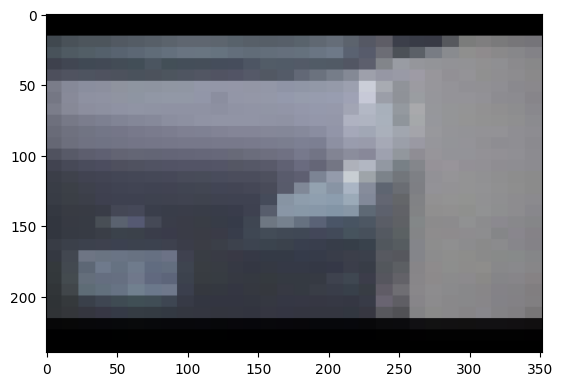

In [18]:
img5 = img.copy()
img5 = pixelate(img5,blocks=30)

RGB_img = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

60
0
206.0
1
204.54000000000002
2
203.07999999999998
3
201.62
4
200.15999999999997
5
198.7
6
197.24
7
195.77999999999997
8
194.32
9
192.86
10
191.39999999999998
11
189.94
12
188.48
13
187.02
14
185.56
15
184.10000000000002
16
182.64
17
181.18
18
179.72000000000003
19
178.26
20
176.8
21
175.34000000000003
22
173.88
23
172.42000000000002
24
170.95999999999998
25
169.5
26
168.04000000000002
27
166.57999999999998
28
165.12
29
163.66
30
162.2
31
160.74
32
159.28
33
157.82
34
156.35999999999999
35
154.89999999999998
36
153.44
37
151.98
38
150.52
39
149.06
40
147.60000000000002
41
146.14
42
144.68
43
143.22
44
141.76
45
140.3
46
138.84
47
137.38
48
135.92000000000002
49
134.46
50
133.0
51
131.54
52
130.07999999999998
53
128.62
54
127.16
55
125.69999999999999
56
124.24000000000001
57
122.78
58
121.32
59
119.86000000000001
60
118.39999999999998
61
116.94000000000001
62
115.47999999999999
63
114.02000000000001
64
112.55999999999997
65
111.10000000000002
66
109.63999999999999
67
108.18
68
106.719

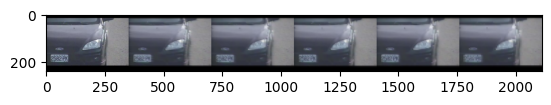

In [19]:
blocks = 60#np.random.randint(120,151)

img5 = img.copy()
_img5 = copy.deepcopy(img5)
print(blocks)
for i in range(101):
    print(i)
    img5p = pixelate(img5,blocks=blocks,step_ratio=i*0.01)
    #dsa
    if i%20==19:
        _img5 = np.concatenate((_img5,img5p),axis=1)
RGB_img5 = cv2.cvtColor(_img5, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img5)
plt.imsave("img_blur.jpg", RGB_img5)


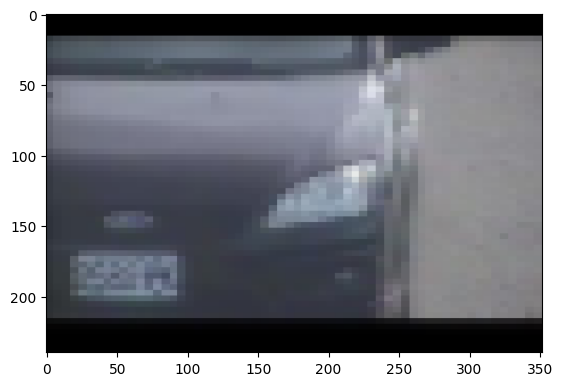

In [20]:
RGB_img5p = cv2.cvtColor(img5p, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img5p)
#for i in range(101):
#    print(i)

top to bottom: raining. spot_light+. spot_light-. adjust gamma. decrease resolution.
left to right: power up


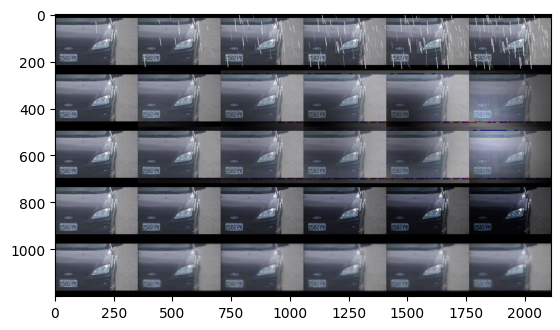

In [21]:
img_allinone=np.concatenate((RGB_img2,RGB_img3p,RGB_img3m,RGB_img4,RGB_img5),axis=0)
plt.imshow(img_allinone)
print('top to bottom: raining. spot_light+. spot_light-. adjust gamma. decrease resolution.')
print('left to right: power up')
plt.imsave("img_allinone.jpg", img_allinone)


# Combine All Effects

In [22]:
def combine_augmentation(input_image):
    #img = copy.deepcopy(input_image)
    img = input_image
    img = add_rain(img)# loop will get gray image.
    img = adjust_gamma(img) # Decrease contrast of image, loop will get black image.
    img = add_spot_light(img) # Darken image.
    img = add_spot_light_randreverse(img) #random bright or dark light.
    img = pixelate(img)# loop this turn will get avg of all.
    return img


125.0
127.0
127.0
140.0
134.0
123.0


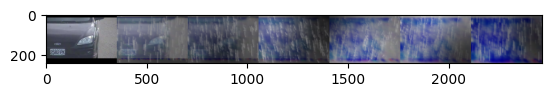

In [23]:
img6 = img.copy()
img6 = combine_augmentation(img6)
img_ = np.concatenate((img.copy(),img6),axis=1)
for i in range(5):
    img6 = combine_augmentation(img6)
    img_ = np.concatenate((img_,img6),axis=1)
    #img_ = img6

RGB_img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
    
plt.imsave("img_allinone_class_.jpg", RGB_img)

#img6 = add_rain(img6)
#img6 = add_spot_light(img6, reverse=True) # Darken image
#img6 = adjust_gamma(img6) # Decrease contrast of image
#img6 = add_spot_light(img6, max_brightness=220)
#img6 = add_spot_light(img6) # Darken image

#img6 = pixelate(img6)
#img_ = np.concatenate((img.copy(),img6))

#RGB_img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
#plt.imshow(RGB_img)

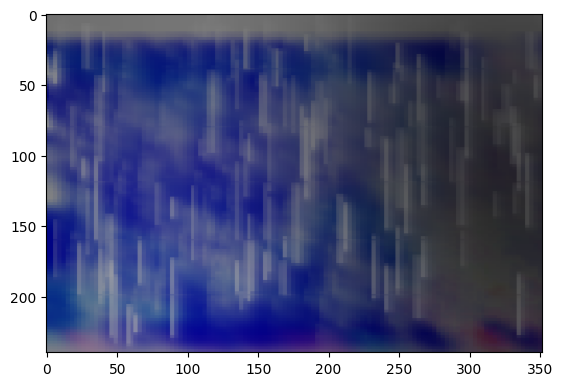

In [24]:
RGB_img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img6)


# In training stage

In [25]:
class mix_augmentaion():
    def __init__(self):
        self.random_parameter()
    def random_parameter(self,rain_slant=None,spotlignt_position=None,spotlight_reverse=None,spotlight_transparency=None,gamma=None,pixelate_blocks=None):
        #rain
        if rain_slant is None:
            rain_slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
        #spot_light
        if spotlight_reverse is None:
            spotlight_reverse=False
            if np.random.random(size=1)>0.5:
                spotlight_reverse=True
        if spotlight_transparency is None:
            spotlight_transparency = random.uniform(0.5, 0.85)
        if spotlignt_position is None:
            spotlignt_position = [(random.random(), random.random())]

        #gamma
        if gamma is None:
            gamma = np.random.randint(40,91) / 100.0
        if pixelate_blocks is None:
            pixelate_blocks = np.random.randint(53,77)#0.2 : 0.3 hw
        
        self.rain_slant = rain_slant
        self.rain_drops = None
        self.rain_width = None

        self.spotlight_reverse = spotlight_reverse
        self.spotlight_transparency = spotlight_transparency
        self.spotlignt_position = spotlignt_position
        self.gamma = gamma
        self.pixelate_blocks = pixelate_blocks
    

        

        
    def generate_random_lines(self,imshape, slant,step_ratio=1.0):
        drops = []
        drop_width = []
        area = imshape[0] * imshape[1]
        drops_num = int(area//np.random.randint(600, 700)*step_ratio)

        for i in range(drops_num): ## If You want heavy rain, try increasing this
            if slant<0:
                x1 = np.random.randint(slant, imshape[1])
            else:
                x1 = np.random.randint(0, imshape[1]-slant)
            drop_length = np.random.randint(10, 60)
            y1 = np.random.randint(0, imshape[0]-drop_length)
            x2 = x1 + slant
            y2 = y1 + drop_length
            drops.append((x1, y1, x2, y2))
            drop_width.append(np.random.randint(1, 3))


        return drops,drop_width


    def rain_process(self,image, rain_drops, drop_color,_drop_width):
        imshape = image.shape  
        image_t = image.copy()
        for idx,rain_drop in enumerate(rain_drops):
            pt1 = (rain_drop[0], rain_drop[1])
            pt2 = (rain_drop[2], rain_drop[3])
            drop_width = _drop_width[idx]
            cv2.line(image_t, pt1, pt2, drop_color, drop_width)

        return image_t


    def add_rain(self,image, slant=None, drop_color=(200,200,200)):
        imshape = image.shape
        if slant is None:
            slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
        rain_drops = self.generate_random_lines(imshape, slant)
        output = self.rain_process(image, rain_drops, drop_color)

        return output

    def add_rain_step(self,image, slant=None, drop_color=(200,200,200),step_ratio=1.0,return_slant=False):
        imshape = image.shape
        if slant is None:
            slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
        if self.rain_drops is None:
            self.rain_drops, self.rain_width = self.generate_random_lines(imshape, slant)
            
        rain_drops = self.rain_drops
        rain_width = self.rain_width
        len_rain = len(rain_drops)
        final_rains = rain_drops[:int(step_ratio*len_rain)]
        final_rain_width = rain_width[:int(step_ratio*len_rain)]
        
        output = self.rain_process(image, final_rains, drop_color,final_rain_width)
        if return_slant:
            return output,slant
        else:
            return output



    def generate_spot_light_mask(self,
                                 mask_size,
                                 position=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None,
                                 speedup=False,
                                 reverse=False):
        """
        Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
        Args:
            mask_size: tuple of integers (w, h) defining generated mask size
            position: list of tuple of integers (x, y) defining the center of spotlight light position,
                      which is the reference point during rotating, format=[(w1,h1), (w2,h2)]
            max_brightness: integer that max brightness in the mask
            min_brightness: integer that min brightness in the mask
            mode: the way that brightness decay from max to min: linear or gaussian
            linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
            speedup: use `shrinkage then expansion` strategy to speed up vale calculation
            reverse: center point is dark or bright (default: bright)
        Return:
            light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                        minimum value could be smaller than given min_brightness.
        """
        if position is None:
            position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
        if linear_decay_rate is None:
            if mode == "linear_static":
                linear_decay_rate = random.uniform(0.25, 1)
        assert mode in ["linear", "gaussian"], \
            "mode must be linear_dynamic, linear_static or gaussian"
        mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
        if mode == "gaussian":
            mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
            dev = mu / 3.5
            mask = self._decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
        mask = np.asarray(mask, dtype=np.uint8)
        # add median blur
        mask = cv2.medianBlur(mask, 5)
        if reverse:
            mask = 255 - mask
        return mask

    def _decay_value_radically_norm_in_matrix(self,mask_size, centers, max_value, min_value, dev):
        """
        _decay_value_radically_norm function in matrix format
        """
        center_prob = norm.pdf(0, 0, dev)
        x_value_rate = np.zeros((mask_size[1], mask_size[0]))
        for center in centers:
            coord_x = np.arange(mask_size[0])
            coord_y = np.arange(mask_size[1])
            xv, yv = np.meshgrid(coord_x, coord_y)
            dist_x = xv - center[0]
            dist_y = yv - center[1]
            dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
            x_value_rate += norm.pdf(dist, 0, dev) / center_prob
        mask = x_value_rate * (max_value - min_value) + min_value
        mask[mask > 255] = 255
        return mask



    def add_spot_light_step(self,image, light_position=None, max_brightness=255, min_brightness=0,
                       mode='gaussian', linear_decay_rate=None, transparency=None,step_ratio=1.0,reverse=False):
        """
        Add mask generated from spot light to given image
        """
        image=copy.deepcopy(image)
        reverse=False
        if np.random.random(size=1)>0.5:
            reverse=True
        if transparency is None:
            transparency = random.uniform(0.5, 0.85)
        transparency = 1-(1-transparency)*step_ratio
        frame = image
        frame = np.asarray(frame, dtype=np.float32)
        height, width, _ = frame.shape
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = self.generate_spot_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate,
                                        reverse=reverse,
                                       )
        hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
        #print(width)
        #print(height)
        #plt.imshow(mask)
        frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        frame[frame > 255] = 255
        frame[frame < 0] = 0
        frame = np.asarray(frame, dtype=np.uint8)
        return frame

    def adjust_gamma(self,image, gamma=1.0):
        image=copy.deepcopy(image)
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        if gamma == 1.0:
            gamma = np.random.randint(40,91) / 100.0
            #gamma = np.random.randint(50,150) / 100.0
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                          for i in np.arange(0, 256)]).astype("uint8")
        # apply gamma correction using the lookup table
        #print(table)
        return cv2.LUT(image, table)

    def pixelate(self,image, blocks=None,step_ratio=1.0):
        input_image_copy=copy.deepcopy(image)
        # divide the input image into NxN blocks
        st_ratio=0.5+step_ratio*0.5
        if blocks is None:
            blocks = np.random.randint(120,151)

        (h, w) = image.shape[:2]
        #Xblocks=w-(w-blocks)*step_ratio
        #Yblocks=h-(h-blocks)*step_ratio
        Xblocks=blocks*st_ratio+(1-st_ratio)*w
        Yblocks=blocks*st_ratio+(1-st_ratio)*h
        #print(Xblocks)


        xSteps = np.linspace(0, w, int(Xblocks) + 1, dtype="int")
        ySteps = np.linspace(0, h, int(Yblocks) + 1, dtype="int")
        #print(len(xSteps),len(ySteps))

        #print(xSteps)
        #print(h)
        #print(w)
        # loop over the blocks in both the x and y direction
        limited=False
        for i in range(1, len(ySteps)):
            for j in range(1, len(xSteps)):
                # compute the starting and ending (x, y)-coordinates
                # for the current block
                startX = xSteps[j - 1]
                startY = ySteps[i - 1]
                endX = xSteps[j]
                endY = ySteps[i]
                if endX-startX<2 and endY-startY<2:
                    #limited=True
                    #print('%d %d %d %d'%(startX,endX,startY,endY))

                    #print('limited to original image')
                    break

                roi = input_image_copy[startY:endY, startX:endX]
                #print(roi)
                #print('%d %d %d %d'%(startX,endX,startY,endY))
                (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]

                cv2.rectangle(input_image_copy, (startX, startY), (endX, endY), (B, G, R), -1)
            #if limited:
            #    break
        # return the pixelated blurred image
        if limited:
            return image
        else:
            return input_image_copy
        
    def pixelate_cv2(self,image, blocks=None,step_ratio=1.0):
        input_image_copy=copy.deepcopy(image)
        # divide the input image into NxN blocks
        st_ratio=0.5+step_ratio*0.5

        if blocks is None:
            blocks = np.random.randint(120,151)

        (h, w) = image.shape[:2]
        Xblocks=blocks*st_ratio+(1-st_ratio)*w
        Yblocks=blocks*st_ratio+(1-st_ratio)*h

        img = cv2.resize(input_image_copy,(int(Xblocks),int(Yblocks)),interpolation=cv2.INTER_AREA)
        #print(img.shape)
        img = cv2.resize(img,(w, h),interpolation=cv2.INTER_AREA)
        return img

        
        
    def mix_aug(self,img,step,random=False):
        if random:
            self.random_parameter()
            
        height, width, _ = img.shape
        pos = [(self.spotlignt_position[0][0]*width,self.spotlignt_position[0][1]*height)]
        #self.pixelate_blocks=60
        img = self.add_rain_step(img,step_ratio=step,slant = self.rain_slant)
        img = self.add_spot_light_step(img,step_ratio=step,light_position=pos,transparency=self.spotlight_transparency,reverse=self.spotlight_reverse)
        img = self.adjust_gamma(img,gamma=1-(1-self.gamma)*step)
        #img = self.pixelate(img,blocks=self.pixelate_blocks,step_ratio=step)
        img = self.pixelate_cv2(img,blocks=self.pixelate_blocks,step_ratio=step)

        #img = self.pixelate_cv2(img,blocks=self.pixelate_blocks,step_ratio=step)

        return img
        



255
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


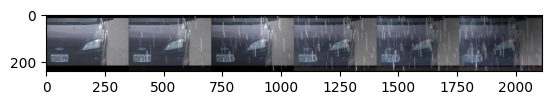

In [26]:
mix_a = mix_augmentaion()
img7 = img.copy()
print(np.max(img7))
#img7 = mix_a.mix_aug(img7,0)
#img_= np.concatenate((img.copy(),img7),axis=1)

for i in range(100):
    print(i)
    img7p = mix_a.mix_aug(img7,i*0.01)

    if i==0:
        img_= img.copy()
    if i%20==19:
        img_= np.concatenate((img_,img7p),axis=1)


RGB_img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.imsave("img_allinone_class2.jpg", RGB_img)

        

In [27]:
blocks

60

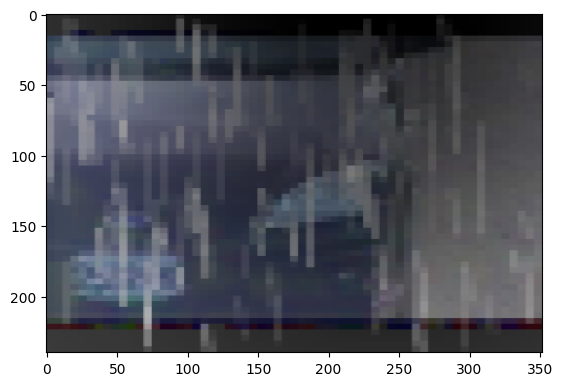

In [28]:
RGB_img7p = cv2.cvtColor(img7p, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img7p)
